# TEXT CLASSIFICATION USING LSTM WITH GLOVE EMBEDDINGS

In [28]:
import numpy as np
import pandas as pd
import string
import itertools
import os
import re
import IPython
import sklearn
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import GlobalMaxPooling1D, Embedding, Input, Concatenate, Conv1D, MaxPooling1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_confusion_matrix(cm, classes,                          
                          title='CONFUSION MATRIX',
                          cmap=plt.cm.PuBu):               # originally plt.cm.Blues; also good: BuPu,RdPu,PuRd,OrRd,Oranges
    '''
    Plot the confusion matrix    
    '''
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
            
    plt.figure(figsize=(5,5))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()
    plt.show()

In [3]:
# UNCOMMENT TO DOWNLOAD AND UNZIP GLOVE VECTORS
#os.chdir(project_path)
#!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip                        # Linux
#!curl http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip -o glove.6B.zip        # Mac OS

In [4]:
#!unzip glove.6B.zip
#!ls
#!pwd

## 1. Prepare data

In [ ]:
file = './data/file_trainValTestsplit.tsv'
df = pd.read_csv( file , sep='\t', encoding='utf-8' )
df['sentence_lower'] = df['sentence'].apply( lambda x: x.lower() )
df['target'] = df['label'].apply( lambda x: 0 if x=='unk' else 1)
print( 'Data size:', df.shape )
print( 'Unique sentences:', len( df['sentence'].unique() ) )
df.isna().sum()

In [ ]:
df.head(2)

In [7]:
# DROP SUBTLE LABELS
print( df.shape )
df = df[ df['is_subtle'] == 0 ]
print( df.shape )

(10981, 16)
(9543, 16)


In [9]:
def mask_names( text_ ):
    
    doc = nlp( text_ )
    if any(t.ent_type_ == 'PERSON' for t in doc):
        text_ = ' '.join([ 'Name' if t.ent_type_=='PERSON' else t.text for t in doc ])
        #print( text_ )
    
    return text_

nlp = spacy.load("en_core_web_lg")
df['sentence'] = df['sentence'].apply( mask_names )
df['sentence_lower'] = df['sentence'].apply( lambda x: x.lower() )
del nlp

In [12]:
# IF NEEDED, REMOVE DIGITS
def remove_digits(s):
    remove = str.maketrans('', '', string.digits)
    return s.translate( remove )

#df['sentence_lower'] = df['sentence_lower'].apply( remove_digits )

In [13]:
# REMOVE STOPWORDS
def only_alpha(s):
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = s.translate(str.maketrans('', '', string.digits))
    return s.lower().strip()
    
def remove_stopwords(s):
    s = s.strip().split()
    s = [ w for w in s if only_alpha(w) not in sw ]
    return ' '.join(s)

sw = [ 'a', 'an', 'the', 'of', 'thank', ]
df['sentence_lower'] = df['sentence_lower'].apply( remove_stopwords )

In [14]:
# TOTAL NUM OF UNIQUE WORDS (very approx. because punctuation is included)
print( 'Unique uppercase words:' , len(set(' '.join(df['sentence'].tolist()).split())) )
print( 'Unique lowercase words:' , len(set(' '.join(df['sentence_lower'].tolist()).split())) )

df['length'] = df['sentence_lower'].apply( lambda x: len(x.split()) )
print( 'Maximum sentence length:', df['length'].max() )
maxlen = df['length'].max()

Unique uppercase words: 16898
Unique lowercase words: 14993
Maximum sentence length: 114


In [15]:
# TRAIN / TEST SPLIT
print( df.shape )
df_test  = df[ df['subset'] == 'test' ]
df_train = df[ df['subset'].isin([ 'train', 'val' ]) ]
print( 'Train set:', df_train.shape )
print( 'Test set: ', df_test.shape )

(9543, 17)
Train set: (8626, 17)
Test set:  (812, 17)


In [16]:
X_train, y_train, X_test, y_test = df_train['sentence_lower'], df_train['target'], df_test['sentence_lower'], df_test['target']
print('Shape of data:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shape of data: (8626,) (812,) (8626,) (812,)


In [17]:
# KERAS TOKENIZER
tokenizer = Tokenizer(num_words=20000, lower=True, oov_token='oov')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size:', vocab_size)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Vocabulary size: 9970


In [18]:
# LOAD WORD2VEC VECTORS FOR OUR VOCABULARY
word_vectors = KeyedVectors.load_word2vec_format('./pretrained_embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [19]:
# LOAD PRETRAINED WORD2VEC EMBEDDINGS
EMBED_SIZE=300
embedding_matrix = np.zeros((vocab_size, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    #if i>=NUM_WORDS:
    #    continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBED_SIZE)

del(word_vectors)

In [26]:
# LOAD GLOVE VECTORS FOR OUR VOCABULARY
embeddings_dictionary = dict()
EMBED_SIZE = 300

glove_file = open('pretrained_embeddings/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, EMBED_SIZE))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## 2. CNN Model #1

In [20]:
# MODEL ARCHITECTURE
learning_rate = 1e-3
batch_size = 64

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, EMBED_SIZE, weights=[embedding_matrix], trainable=False)(deep_inputs)
stride = 5
size   = 128
x = Conv1D(size, stride, activation="relu", padding="same")(embedding_layer)
x = MaxPooling1D(stride)(x)
x = Conv1D(size, stride, activation="relu", padding="same")(x)
x = MaxPooling1D(stride)(x)
x = Conv1D(size, stride, activation="relu", padding="same")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(size, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x)
model = Model(inputs=deep_inputs, outputs=preds)

model.compile( loss='binary_crossentropy', optimizer=RMSprop(lr=learning_rate), metrics=['accuracy'] )
#print(model.summary())

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(
                                               monitor='val_accuracy',
                                               patience=5,
                                               restore_best_weights=True,
                                           )
history = model.fit( X_train,
                     y_train,
                     batch_size=batch_size,
                     epochs=25,
                     verbose=1,
                     validation_split=0.2,
                     callbacks=[early_stop]
                    )

Epoch 1/25
108/108 [==============================] - 10s 80ms/step - loss: 0.6650 - accuracy: 0.5996 - val_loss: 0.5877 - val_accuracy: 0.6883
Epoch 2/25
108/108 [==============================] - 6s 57ms/step - loss: 0.5393 - accuracy: 0.7247 - val_loss: 0.5097 - val_accuracy: 0.7503
Epoch 3/25
108/108 [==============================] - 6s 52ms/step - loss: 0.4666 - accuracy: 0.7800 - val_loss: 0.4927 - val_accuracy: 0.7694
Epoch 4/25
108/108 [==============================] - 6s 57ms/step - loss: 0.3726 - accuracy: 0.8314 - val_loss: 0.5106 - val_accuracy: 0.7723
Epoch 5/25
108/108 [==============================] - 6s 56ms/step - loss: 0.2849 - accuracy: 0.8821 - val_loss: 0.5563 - val_accuracy: 0.7885
Epoch 6/25
108/108 [==============================] - 6s 53ms/step - loss: 0.2205 - accuracy: 0.9096 - val_loss: 0.7069 - val_accuracy: 0.7619
Epoch 7/25
108/108 [==============================] - 6s 56ms/step - loss: 0.1595 - accuracy: 0.9436 - val_loss: 0.9213 - val_accuracy: 0.747

In [38]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

26/26 [==============================] - 1s 19ms/step - loss: 0.8205 - accuracy: 0.7611
Test Score: 0.8204634189605713
Test Accuracy: 0.761083722114563


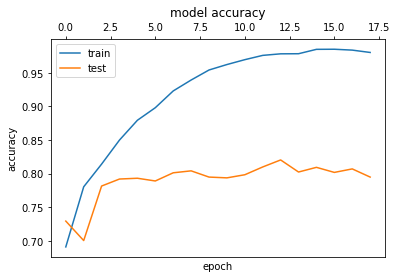

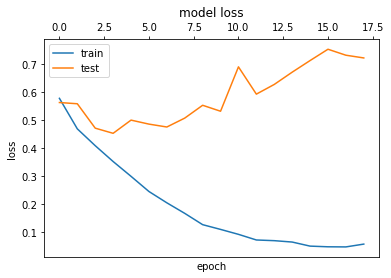

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [40]:
# PREDICT ALL
predictions = model.predict(X_test)
predictions = np.round( predictions )

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       492
           1       0.68      0.75      0.71       320

    accuracy                           0.76       812
   macro avg       0.75      0.76      0.75       812
weighted avg       0.77      0.76      0.76       812



<Figure size 432x288 with 0 Axes>

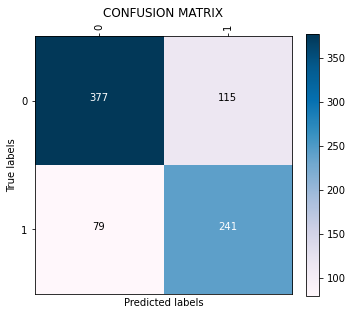

In [41]:
#labels = [ '0', '1' ]
print(classification_report(y_test, predictions))# target_names=labels))

# PRINT THE CONFUSION MATRIX
labels = list( range( len(np.unique(y_test))))
cm = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=labels)

### CNN Model #2

In [29]:
def cnn_module(inputs, filters, widths):
    t1 = keras.layers.Conv1D(filters, widths[0], padding="same")(inputs)
    t1 = keras.layers.BatchNormalization()(t1)
    t1 = keras.layers.LeakyReLU()(t1)
    t2 = keras.layers.Conv1D(filters, widths[1], padding="same")(inputs)
    t2 = keras.layers.BatchNormalization()(t2)
    t2 = keras.layers.LeakyReLU()(t2)
    t3 = keras.layers.Conv1D(filters, widths[2], padding="same")(inputs)
    t3 = keras.layers.BatchNormalization()(t3)
    t3 = keras.layers.LeakyReLU()(t3)
    co = keras.layers.Concatenate()([t1, t2, t3])
    return co


In [ ]:
learning_rate = 1e-3
batch_size    = 64
units         = 32
dropout       = 0.5

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, EMBED_SIZE, weights=[embedding_matrix], trainable=False)(deep_inputs)
cnn1 = cnn_module(embedding_layer, 16, [1, 2, 3])
cnn2 = cnn_module(cnn1, 32, [1, 2, 3])
cnn2 = cnn_module(cnn2, 64, [1, 2, 3])
cnn2 = cnn_module(cnn2, 32, [1, 2, 3])
cnn2 = cnn_module(cnn2, 32, [1, 2, 3])
cnn2 = cnn_module(cnn2, 32, [1, 2, 3])
#rnn = keras.layers.Bidirectional(keras.layers.GRU(8))(cnn2)
#rnn = keras.layers.Dropout(0.1)(rnn)
#rnn = keras.layers.Bidirectional(keras.layers.GRU(16), merge_mode='sum')(cnn2)
rnn = keras.layers.Bidirectional(keras.layers.LSTM(units, dropout=0.0))(cnn2)
out = keras.layers.Dense(1, activation="sigmoid")(rnn)

model = Model(inputs=deep_inputs, outputs=out)

model.compile( loss='binary_crossentropy', optimizer=Nadam(lr=learning_rate), metrics=['accuracy'] )
#print(model.summary())

In [37]:
early_stop = tf.keras.callbacks.EarlyStopping(
                                               monitor='val_accuracy',
                                               patience=5,
                                               restore_best_weights=True,
                                           )
history = model.fit( X_train,
                     y_train,
                     batch_size=batch_size,
                     epochs=25,
                     verbose=1,
                     validation_split=0.2,
                     callbacks=[early_stop]
                    )

Epoch 1/25
108/108 [==============================] - 35s 230ms/step - loss: 0.6194 - accuracy: 0.6508 - val_loss: 0.5629 - val_accuracy: 0.7294
Epoch 2/25
108/108 [==============================] - 22s 205ms/step - loss: 0.4752 - accuracy: 0.7799 - val_loss: 0.5585 - val_accuracy: 0.7005
Epoch 3/25
108/108 [==============================] - 23s 208ms/step - loss: 0.4165 - accuracy: 0.8090 - val_loss: 0.4715 - val_accuracy: 0.7816
Epoch 4/25
108/108 [==============================] - 22s 201ms/step - loss: 0.3411 - accuracy: 0.8573 - val_loss: 0.4531 - val_accuracy: 0.7920
Epoch 5/25
108/108 [==============================] - 21s 198ms/step - loss: 0.2910 - accuracy: 0.8861 - val_loss: 0.5002 - val_accuracy: 0.7932
Epoch 6/25
108/108 [==============================] - 22s 201ms/step - loss: 0.2330 - accuracy: 0.9045 - val_loss: 0.4860 - val_accuracy: 0.7891
Epoch 7/25
108/108 [==============================] - 21s 198ms/step - loss: 0.1890 - accuracy: 0.9330 - val_loss: 0.4757 - val_ac

In [42]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

26/26 [==============================] - 0s 15ms/step - loss: 0.8205 - accuracy: 0.7611
Test Score: 0.8204634189605713
Test Accuracy: 0.761083722114563


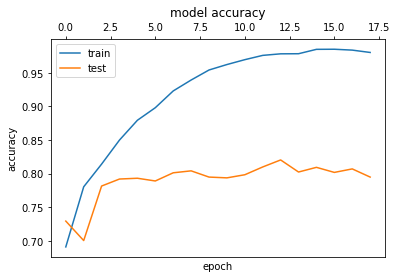

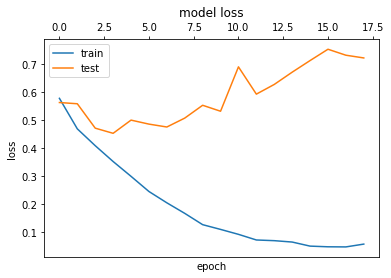

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [44]:
# PREDICT ALL
predictions = model.predict(X_test)
predictions = np.round( predictions )

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       492
           1       0.68      0.75      0.71       320

    accuracy                           0.76       812
   macro avg       0.75      0.76      0.75       812
weighted avg       0.77      0.76      0.76       812



<Figure size 432x288 with 0 Axes>

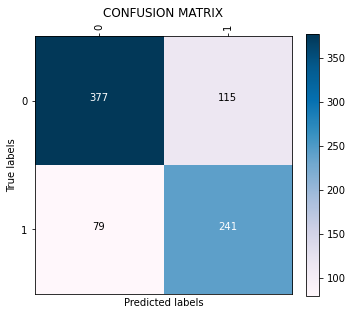

In [45]:
#labels = [ '0', '1' ]
print(classification_report(y_test, predictions))# target_names=labels))

# PRINT THE CONFUSION MATRIX
labels = list( range( len(np.unique(y_test))))
cm = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=labels)

## Keras Model Hyperparameter Tuning

In [ ]:
#!pip install -q -U keras-tuner

In [ ]:
df['label'].value_counts()

In [ ]:
# downsize corpus
def downsample_balanced(X_train_, y_train_):

    # how many samples to resample w/raplacement - based on analysis of doc count + word count per category
    # (=balanced upsampling, not just using doc count because some categories have a lot more docs, but they are shorter
    # which means that you have to add not as many docs to the underrepresented category because its docs are longer)
    dict_upsample = {0: 2000,
                     1: 3000,
                     2: 3000,
                     3: 5000,
                     4: 5000,
                     5: 4000,
                     6: 5000,}
    
    downsampled_dfs = []
    for k in dict_upsample:

        category      = k
        num_to_sample = dict_upsample[k]

        if num_to_sample != 0:

            temp_all_categories = pd.DataFrame( {'X_train': X_train_, 'y_train': y_train_} )
            temp_one_category   = temp_all_categories[ temp_all_categories['y_train'] == category ]            
            downsampled_dfs.append(temp_one_category.sample( num_to_sample, replace=False ))
            print('Downsampled category {} to {} samples'.format(k, dict_upsample[k]))
            
    temp_all_categories = sklearn.utils.shuffle(pd.concat(downsampled_dfs))
    X_train_ = temp_all_categories[ 'X_train' ]
    y_train_ = temp_all_categories[ 'y_train' ]            

    print('Shape of downsampled datasets:', X_train_.shape, y_train_.shape)
        
    return X_train_, y_train_

In [ ]:
X_train, y_train = downsample_balanced(X_train, y_train)

In [ ]:
import kerastuner as kt

def model_builder(hp):
        
    #model = keras.Sequential()
    #model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer  
    #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    #model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer  
    #hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    #model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
    #              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
    #              metrics = ['accuracy'])

    deep_inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size, EMBED_SIZE, weights=[embedding_matrix], trainable=False)(deep_inputs)
    #spatial_dropout = SpatialDropout1D(0.25)(embedding_layer)

    hp_units = hp.Int('units', min_value = 64, max_value = 512, step = 64)
    hp_dropout = hp.Choice('dropout', values = [0.05, 0.1, 0.15, 0.2])
    LSTM_Layer_1 = Bidirectional(LSTM(units = hp_units, dropout=hp_dropout, return_sequences=True))(embedding_layer)    # recurrent_dropout=0.2
    LSTM_Layer_2 = Bidirectional(LSTM(units = hp_units, dropout=hp_dropout))(LSTM_Layer_1)
    dense_layer_1 = Dense(7, activation='softmax')(LSTM_Layer_2)
    model = Model(inputs=deep_inputs, outputs=dense_layer_1)

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(lr=hp_learning_rate), metrics=['accuracy'])
    print(model.summary())

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = './tuner',
                     project_name = 'kt_hb')

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

In [ ]:
# Get the optimal hyperparameters
# previous run - lr=0.001, units-512
best_model = tuner.get_best_models(1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print('Best model:', best_model)
print('Best hyperparameters:', best_hps.values)

In [ ]:
best_hps.values